## This script creates plots from the CSV files created by the time_to_space_latlon_conversion3.ipynb script
### By Jessica McDonald, adapted from Aaron Hill. 8/17
Before this script is used, the user must edit:
1. target date
2. start time, duration, and radar analysis time
3. reference latitude and longitude
4. plotting/interpolation grid
5. variable (run the corresponding cell)
NOTE: PLACE "pert" IN THE SAVE PATH IF IT IS A PERTURBATION PLOT
6. the contour range may need to be adjusted

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import pandas as pd
from pylab import cm
import scipy.ndimage as nd
from functions_radar3 import get_radar_from_aws,_nearestDate
from mpl_toolkits.basemap import Basemap
import pyart;
import datetime as dt
from netCDF4 import num2date
import pytz


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## User edit variables for date and plotting info

In [3]:
# Specify the date of the event, along with the directory where data is stored
#target_date = '20160331'
#target_date = '20170430'
target_date = '20160430'
#target_date = '20160429'
#target_date = '20170325'

# use the following to help open the correct file... otherwise type in the filename manually
if target_date == '20160331':
    # 160331
    start_hour = 21 
    start_min =40
    start_sec = 0
    duration = 75  #in minutes
    analysis_time = dt.datetime(2016,3,31,22,9)
    # 3/31 2016 VSE
    ref_elevation = 250;
    ref_lat = 35.1;
    ref_lon = -87.7;
    #grid
    yi = np.arange(34.9,35.21,0.001)
    xi = np.arange(-88.1,-87.52,0.001)
    X,Y = np.meshgrid(xi,yi)
    
if target_date == '20170430':
    # 20170430
    #midpoint is 1837... 30 mins on either side
    start_hour = 18
    start_min = 7
    start_sec = 0
    duration = 60 
    analysis_time = dt.datetime(2017,4,30,18,37)
    # 4/30 2017 VSE   
    ref_lat = 34.5
    ref_lon = -87.2
    ref_elevation = 174.3
    yi = np.arange(ref_lat - .44,ref_lat+.14,0.001)
    xi = np.arange(ref_lon - .4,ref_lon+.2,0.001)
    X,Y = np.meshgrid(xi,yi)
    
if target_date == '20160430':   
    # 160430
    start_hour = 20
    start_min = 59
    start_sec = 0
    duration = 60
    analysis_time = dt.datetime(2016,4,30,21,29) # for radar image
    ref_lat = 34.5
    ref_lon = -87.3
    ref_elevation = 179.2

# Reference elevation, latitude, and longitude to center the analysis on



# 4/29 2016
# ref_elevation = 200
# ref_lat = 33.8
# ref_lon = -87.64

# 3/25 2017
#ref_elevation = 200
#ref_lat = 34.53
#ref_lon = -87.31

# don't edit this part
directory = '/home/jessmcd/VortexSE/'+target_date+'/Time2Space/'
output_directory = directory+'figs'
year,month,day = (target_date[0:4],target_date[4:6],target_date[6:8])
span = [(dt.datetime(int(year),int(month),int(day),start_hour,start_min)).strftime('%H%M'),\
        (dt.datetime(int(year),int(month),int(day),start_hour,start_min)+\
         dt.timedelta(minutes = duration)).strftime('%H%M')]


## Plotting functions

In [4]:
def convert_lon_lat(ref_lon,ref_lat,x,y):
    ''' This function takes a reference lon and lat (the location of the radar) and converts the x and y 
    coordinates in km from the radar (radar._get_x_y(...) into lons and lats for plotting on basemap)'''
    # Convert lat/lon to meters for conversion in a cartesian grid
    m1 = 111132.92  #lat calc term 1
    m2 = -559.82    #lat calc term 2
    m3 = 1.175      #lat calc term 3
    m4 = -0.0023    #lat calc term 4
    p1 = 111412.84  #lon calc term 1
    p2 = -93.5      #lon calc term 2
    p3 = 0.118      #lon calc term3
    
    x *= 1000
    y *=1000
    
    lat_convert = m1 + (m2*np.cos(np.deg2rad(2*ref_lat)))+(m3*np.cos(np.deg2rad(4*ref_lat)))+(m4*np.cos(np.deg2rad(6*ref_lat)))
    lon_convert = (p1 * np.cos(np.deg2rad(ref_lat))) + (p2 * np.cos(np.deg2rad(3*ref_lat)))+(p3*np.cos(np.deg2rad(5*ref_lat)))

    lon_pos = [(ref_lon+(x_pos/lon_convert)) for x_pos in x]
    lat_pos = [(ref_lat+(y_pos/lat_convert)) for y_pos in y]
    
    lon_pos = np.array(lon_pos)
    lat_pos = np.array(lat_pos)

    return lon_pos,lat_pos

def plot_variable_radar(X,Y,ref_lat, ref_lon, variable, contour_range, radar, file_path, file_path_wind, save_path):

    # create interpolated grid from time2space data 
    data = pd.read_csv(file_path,names=['x_pos','y_pos','val'],header=1)
    zi = interpolate.griddata((data['x_pos'],data['y_pos']),data['val'],(X,Y))

    if contour_range is None:
        clevels = np.arange(np.min(zi),np.max(zi),20)
    else: clevels = contour_range

    # make radar title
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                          radar.time['units'])
    central = pytz.timezone('US/Central')
    local_time = central.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%I:%M %p %Z')
    fancy_date_string_utc = time_at_start_of_radar.strftime('%H%M UTC')
    name = '40 dBZ Contour'
    title   = '\n{0} {1} {2} ({3})'.format(station,name,fancy_date_string,fancy_date_string_utc)

    # get radar data
    display = pyart.graph.RadarMapDisplay(radar)
    radar_lat = display.loc[0]
    radar_lon = display.loc[1]
    lat_1 = 35.5


    # Initialize plot and basemap
    fig = plt.figure(figsize = [15,10])
    ax = fig.add_subplot(111)

    llcrnrlon= X[0][0]
    llcrnrlat= Y[0][-1]
    urcrnrlon= X[0][-1]
    urcrnrlat= Y[-1][-1]
    m = Basemap(resolution = 'i',projection='merc',lat_ts = 35.5,
                    llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,
                    urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat)
    m.drawcounties()

    #plot time-to-space data grid
    xx, yy = m(X,Y)
    C = m.contourf(xx,yy, nd.filters.gaussian_filter(zi,2.0),levels=clevels,cmap=cm.RdBu_r, alpha = 0.7)
    m.contour(xx,yy, nd.filters.gaussian_filter(zi,2.0),levels=C.levels,colors='k', linewidths = 0.5)
    clb = fig.colorbar(C)
    clb.ax.set_title('K')
    
    # title
    ax.set_title(obtitle+title, fontsize = 14, y = 1.01)
    
    #plot radar contour
        
    # get reflectivity
    field, sweep = ('reflectivity',0)
    x,y = display._get_x_y(sweep = sweep, edges = False, filter_transitions = True)
    data = radar.get_field(sweep,field)
    data = nd.gaussian_filter(data, sigma = 1.2)
    #convert coordinates from km to lat/lon
    lon_pos,lat_pos = convert_lon_lat(radar_lon,radar_lat,x,y)
    
    m.contour(lon_pos,lat_pos,data, levels = [40], latlon = True, colors = '#8F8F8F', linewidths = 4)
    
    # plot velocity
#     field, sweep = ('velocity',1)
#     x,y = display._get_x_y(sweep = sweep, edges = False, filter_transitions = True)
#     data = radar.get_field(sweep,field)
#     data = nd.gaussian_filter(data, sigma = 1.2)
    
#     m.contour(lon_pos,lat_pos,data, levels = [-60], latlon = True, colors = 'b', linewidths = 1)

    #wind data
    data_wind = pd.read_csv(file_path_wind,names=['id','time','u_comp','v_comp','x_pos','y_pos'],header=1)
    wind = np.sqrt((np.array(data_wind['u_comp'].values)**2) + (np.array(data_wind['v_comp'].values)**2))

    m.barbs(data_wind['x_pos'].values[::100],data_wind['y_pos'].values[::100],
            data_wind['u_comp'].values[::100]*1.94384,data_wind['v_comp'].values[::100]*1.94384, latlon = True)

    #save figure
    plt.savefig(save_path,dpi=300)
    plt.show() #remove and add savefig command once in function 

## Make Grid

In [13]:
# 160331 - 45 mins
# yi = np.arange(34.85,35.25,0.001)
# xi = np.arange(-88.05,-87.45,0.001)
# X,Y = np.meshgrid(xi,yi)

# 160430
yi = np.arange(34.4,34.6,0.001)
xi = np.arange(-87.50,-87.2,0.001)
X,Y = np.meshgrid(xi,yi)

# yi = np.arange(ref_lat - .44,ref_lat+.27,0.001)
# xi = np.arange(ref_lon - .52,ref_lon+.18,0.001)
# X,Y = np.meshgrid(xi,yi)



### Theta E

293 293


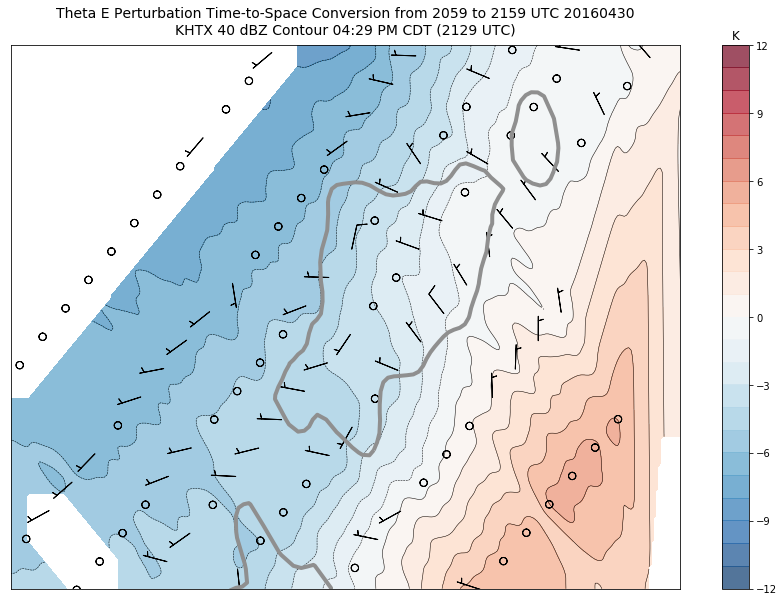

In [14]:
variable = 'theta_e'
obtitle = 'Theta E Perturbation Time-to-Space Conversion from '+span[0]+' to '+span[1]+' UTC '+target_date

file_path = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
file_path_wind = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,'raw_wind',start_hour,start_min,duration)
# add "pert" before {1} if its a perturbation plot
save_path='{0}/pert_{1}_{2}_{3}_{4}.png'.format(output_directory,target_date,variable,'winds', duration)

# get radar data
station = 'KHTX'
field = 'reflectivity'
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]

# plot
#contour_range = np.arange(320,350,1.0) #4/30
#contour_range = np.arange(320,350,1.0)  #3/31
contour_range = np.arange(-12,13,1.0)
plot_variable_radar(X,Y,ref_lat, ref_lon,\
                    variable, contour_range, \
                    radar,\
                    file_path, file_path_wind, save_path)

### Theta V

293 293


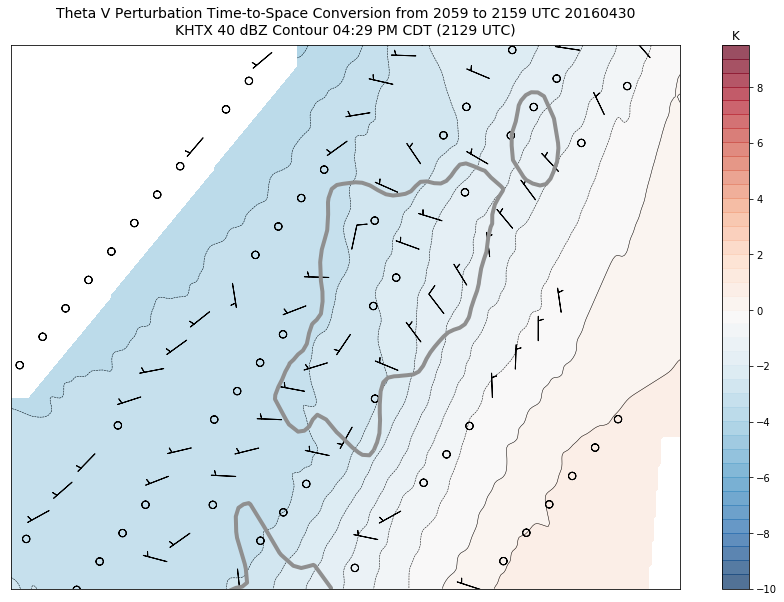

In [15]:
variable = 'theta_v'
obtitle = 'Theta V Perturbation Time-to-Space Conversion from '+span[0]+' to '+span[1]+' UTC '+target_date 

file_path = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,variable,start_hour,start_min,duration)
file_path_wind = '{0}/{1}_{2}_{3}{4}_{5}.csv'.format(output_directory,target_date,'raw_wind',start_hour,start_min,duration)
save_path='{0}/pert_{1}_{2}_{3}_{4}.png'.format(output_directory,target_date,variable,'winds',duration)

# get radar data
station = 'KHTX'
field = 'reflectivity'
radar_namelist, radar_list = get_radar_from_aws(station, analysis_time, analysis_time)
radar = radar_list[0]

# plot
#contour_range = np.arange(292,303,0.5)
contour_range = np.arange(-10,10,0.5)
plot_variable_radar(X,Y,ref_lat, ref_lon,\
                    variable, contour_range, \
                    radar,\
                    file_path, file_path_wind, save_path)

In [16]:
import pandas as pd

data = pd.read_csv('/home/jessmcd/VortexSE/StormEvents_details.csv')
data[]